In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from scipy import sparse
import joblib

from final_preprocessing import final_common_preprocessing

In [2]:
# ---------------------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------------------
SUFFIX = "_FINAL"
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")

demographics_path = BASE / "demographics_opioid_sample5M.parquet"
split_spells_path = BASE / f"split_spells{SUFFIX}.parquet"
icd10_path = BASE / f"icd10_codes_from_spells{SUFFIX}_clustered.parquet"

AE_WINDOW_DAYS = 30

# ---------------------------------------------------------------------
# 2. Load data
# ---------------------------------------------------------------------
print("Loading data...")
dem = pd.read_parquet(demographics_path)
spells = pd.read_parquet(split_spells_path)
icd = pd.read_parquet(icd10_path)

df, numeric_cols, cat_cols = final_common_preprocessing(spells, dem, icd, AE_WINDOW_DAYS)

Loading data...
dem shape:    (824793, 6)
spells shape: (1791008, 14)
icd shape:    (1228607, 4)
spells after drug_combo filter: (1577817, 14)
spells after first_ae_date = entry_date filter: (1574785, 14)
spells after moving first_ae_date one day earlier: (1574785, 14)
spells after short no-AE spell filter: (928171, 14) (removed 41.06% rows)
Number of spells with AE 14462
Number of AE within 30 days: 11902
AE within 30 days rate: 0.012823068163086327
Spells before deduplication: 928171
Spells after deduplication: 847894
Number of AE within 30 days after dedup: 11896
Merging tables...
After merging demographics, df shape: (847894, 22)
Combined df shape: (847894, 23)
Number of AE within 30 days after merge: 11896
Number of rows with NaN in birthyear: 2118
Number of rows with None in gender: 0
Filtering out 905 rows (0.11%) where AE ICD prefix appears in icd10_codes (potential leakage).
Number of AE within 30 days after leakage filter: 11092
Rows remaining after leakage filter: 846989
Dro

In [ ]:
from .logreg import prepare_features_and_split

X_train, X_valid, y_train, y_valid, X_base, mlb_drugs, icd_kept_classes = (
    prepare_features_and_split(df, numeric_cols, cat_cols, min_icd_freq=500)
)


Fitting MultiLabelBinarizer for drugs...
Number of drug classes: 200
Fitting MultiLabelBinarizer for ICD10 groups...
Total ICD10 group features: 1986
ICD groups kept (freq >= 500): 938 out of 1986
One-hot encoding demographics...
Stacking feature matrices for logreg...
Final feature matrix shape: (814412, 1154)
Splitting train/validation...
Train positives: 8718, negatives: 642811, scale_pos_weight: 73.73


## Evaluating the results

In [ ]:
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/logreg_models")

# Load model and encoders
logreg = joblib.load(BASE / f"logreg_model_FINAL.joblib")

print("Model loaded.")


Model loaded.


In [6]:
def precision_recall_at_k(y_true, y_proba, frac):
    n = len(y_true)
    k = int(frac * n)
    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]
    precision_k = y_top.mean()            # PPV in the top frac
    recall_k = y_top.sum() / y_true.sum() # proportion of all events captured
    return precision_k, recall_k, k

y_valid_proba = logreg.predict_proba(X_valid)[:, 1]

for frac in [0.001,0.01, 0.05, 0.10]:
    p_k, r_k, k = precision_recall_at_k(y_valid, y_valid_proba, frac)
    print(f"Top {frac*100:.2f}% (n={k}):")
    print(f"  Precision@k: {p_k:.4f}")
    print(f"  Recall@k:    {r_k:.4f}")
    print()


# Build feature name list in the same order as X
base_feature_names = list(X_base.columns)
drug_feature_names = [f"DRUG_{c}" for c in mlb_drugs.classes_]
icd_feature_names  = [f"ICD_{c}" for c in icd_kept_classes]

feature_names = base_feature_names + drug_feature_names + icd_feature_names

coef = logreg.coef_.ravel()
logreg_summary = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "OR": np.exp(coef)
}).sort_values("OR", ascending=False)

print("Top positive features (highest OR):")
print(logreg_summary.head(20))

print("Top negative features (protective):")
print(logreg_summary.tail(20))

Top 0.10% (n=162):
  Precision@k: 0.1605
  Recall@k:    0.0119

Top 1.00% (n=1628):
  Precision@k: 0.0940
  Recall@k:    0.0702

Top 5.00% (n=8144):
  Precision@k: 0.0581
  Recall@k:    0.2170

Top 10.00% (n=16288):
  Precision@k: 0.0457
  Recall@k:    0.3413

Top positive features (highest OR):
        feature      coef        OR
139   DRUG_J04B  1.072789  2.923522
262     ICD_C25  0.943543  2.569067
121   DRUG_H01B  0.879117  2.408773
260     ICD_C21  0.827535  2.287672
181   DRUG_N07B  0.809023  2.245712
272     ICD_C56  0.737173  2.090018
1014    ICD_T15  0.705964  2.025800
450     ICD_G61  0.705572  2.025005
1015    ICD_T16  0.697744  2.009214
757     ICD_M66  0.682781  1.979375
185   DRUG_P01C  0.671548  1.957264
844     ICD_O47  0.659188  1.933222
115   DRUG_G03F  0.630642  1.878817
720     ICD_M11  0.612973  1.845910
141   DRUG_J06B  0.612819  1.845627
90    DRUG_D03A  0.599965  1.822055
691     ICD_L50  0.590763  1.805366
290     ICD_D05  0.578874  1.784028
109   DRUG_G02C  0.

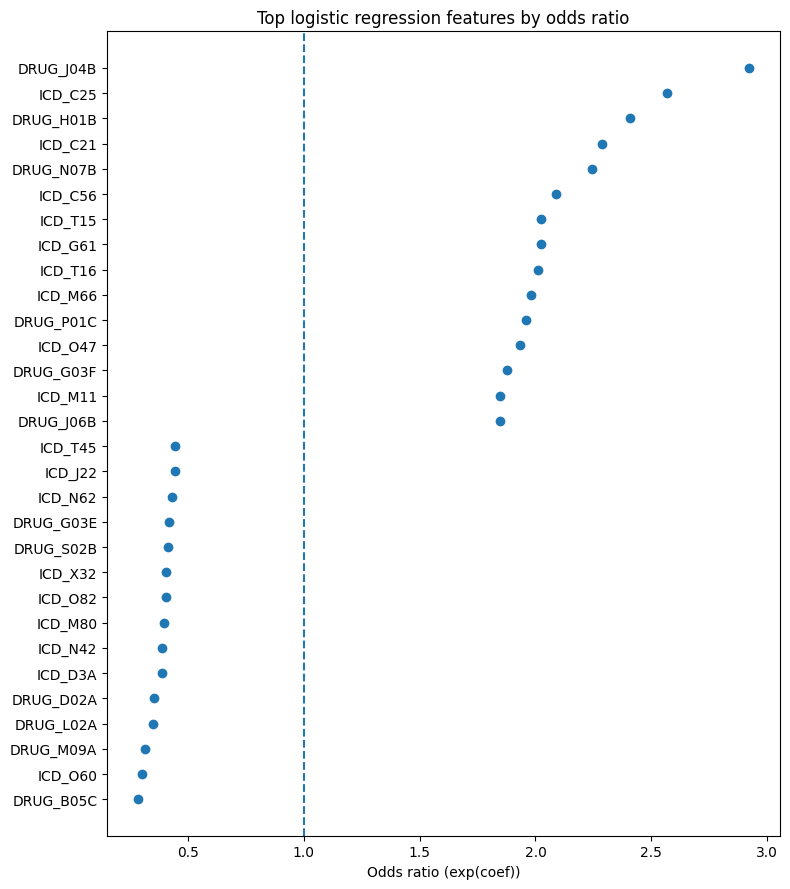

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# logreg_summary is already:
# logreg_summary = pd.DataFrame({
#     "feature": feature_names,
#     "coef": coef,
#     "OR": np.exp(coef)
# }).sort_values("OR", ascending=False)

def plot_odds_ratios(logreg_summary, top_n=30):
    """
    Make a forest-style plot of the top_n features by OR
    (top_n/2 highest ORs and top_n/2 lowest ORs).
    """
    df = logreg_summary.copy()

    # Take top N/2 risk and N/2 protective features
    n_half = top_n // 2

    top_risk = df.sort_values("OR", ascending=False).head(n_half)
    top_prot = df.sort_values("OR", ascending=True).head(n_half)

    # Combine, but keep order (protective at top, then risk)
    plot_df = pd.concat([top_prot, top_risk], axis=0)

    # For nicer labels: shorten very long names
    def shorten(name, maxlen=40):
        return (name[:maxlen] + "…") if len(name) > maxlen else name

    plot_df = plot_df.copy()
    plot_df["label"] = plot_df["feature"].apply(shorten)

    # Sort so that it appears nicely from low OR to high OR
    plot_df = plot_df.sort_values("OR", ascending=True)

    # Plot
    fig, ax = plt.subplots(figsize=(8, max(6, 0.3 * len(plot_df))))

    y_pos = np.arange(len(plot_df))

    ax.scatter(plot_df["OR"], y_pos)

    # Vertical line at OR = 1 (no effect)
    ax.axvline(1.0, linestyle="--")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df["label"])
    ax.set_xlabel("Odds ratio (exp(coef))")
    ax.set_title("Top logistic regression features by odds ratio")

    plt.tight_layout()
    plt.show()

# usage:
plot_odds_ratios(logreg_summary, top_n=30)
